<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/hungarian/machine_learning/lessons/concrete_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Gépi tanitási módszerek regresszióra


A regresszió esetén egy folytonos változó értéket próbálunk megbecsülni. A bemeneti paraméterek és a kimeneti érték közötti összefüggést a tanító adatokból vezetjük le.

## Robosztus lineáris regresszió

A regresszió akkor roboszus, ha néhány kiugró érték nem torzítja el az eredményt.

Egyenes: 0.501 * x + 3.9
Korreláció (tréning): 0.933
Korreláció   (teszt): 0.961


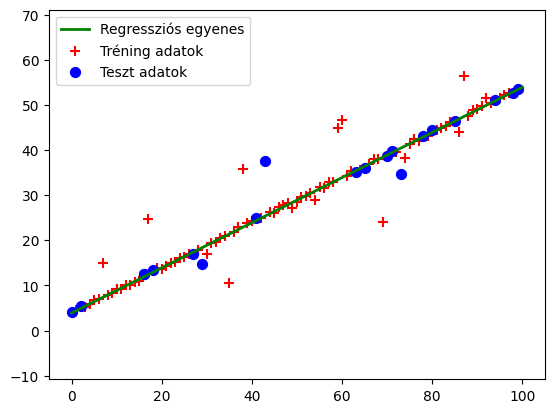

In [73]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import TheilSenRegressor

# adatok generálása
num_points = 100            # minta pontok száma
rnd_points = 20             # nagy hibával terhelt pontok száma
X = np.arange(num_points)
y = 0.5 * X + 4 + np.random.random(size=num_points) - 0.5     # kis zaj minden ponthoz

# nagyobb zaj hozzáadása néhány y értékekehez
noisy = np.random.randint(num_points, size=rnd_points)
y[noisy] = y[noisy] + 30 * (np.random.random(size=rnd_points) - 0.5)

# tréning és teszt adatok szétválasztása véletlenszerűen
indx = np.random.randint(num_points, size=rnd_points)   # véletlen indexek teszt adatokhoz
X_test = X[indx]; y_test = y[indx]
mask = np.ones(num_points, dtype=bool)
mask[indx] = False
X_train = X[mask]; y_train = y[mask]
X_train = np.array(X_train).reshape(-1, 1)
X_test = np.array(X_test).reshape(-1, 1)

reg = TheilSenRegressor()
reg = reg.fit(X_train, y_train)
print(f"Egyenes: {reg.coef_[0]:.3f} * x + {reg.intercept_:.1f}")
y_pred = reg.predict(X_test)
print(f"Korreláció (tréning): {reg.score(X_train, y_train):.3}")
print(f"Korreláció   (teszt): {reg.score(X_test, y_test):.3}")
plt.plot([0, 100], [reg.intercept_, reg.coef_[0] * 100 + reg.intercept_], color='green', linewidth=2, label='Regressziós egyenes')
plt.scatter(X_train, y_train, marker='+', color='red', s=50, label='Tréning adatok')
plt.scatter(X_test, y_test, marker='o', color='blue', s=50, label='Teszt adatok')
plt.legend()
_ = plt.axis('equal')

## Nem lineáris regresszió

A nem lináris regressziót a Support Vector Machine regresszorával oldjuk meg.

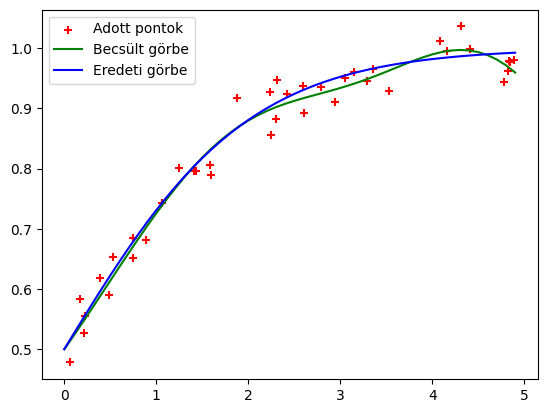

In [82]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.svm import SVR

nump = 40       # pontok száma a mintában
# véletlen adatok generálása sigmoid függvény mentén
X = np.sort(5 * np.random.rand(nump, 1), axis=0)
y = (1.0 / (1.0 + np.exp(-X))).ravel() + 0.1 * (np.random.rand(nump) - 0.5)
svr = SVR(kernel="rbf", C=10, gamma=0.2, epsilon=0.02)   # kernel trükk
svr = svr.fit(X, y)
X_pred = np.arange(0, 5, 0.1).reshape(-1, 1)
y_pred = svr.predict(X_pred)
y_orig = (1.0 / (1.0 + np.exp(-X_pred))).ravel()
plt.scatter(X, y, marker='+', color='red', label='Adott pontok')
plt.plot(X_pred, y_pred, color='green', label='Becsült görbe')
plt.plot(X_pred, y_orig, color='blue', label='Eredeti görbe')
_ = plt.legend()

## Regresszió neurális hálózattal

Beton szilárdság (MPa) meghatározása összetevők és kor (napok) alapján.

Összetevők (kg/m3):

* cement,
* kohósalak (blast furnance slag),
* pernye (fly_ash),
* víz (water),
* szuperlágyító (superplasticizer),
* durva adalékanyag (coarse_aggregate) és
* finom adalékanyag (fine_aggregate)

In [48]:
# adatállomány letöltése eredeti forrás: https://www.kaggle.com/datasets/elikplim/concrete-compressive-strength-data-set
!wget -q https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/machine_learning/lessons/data/concrete_data.csv

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, LayerNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

Adatok betöltése és az első pár sor megjelenítése.

In [50]:
data = pd.read_csv('concrete_data.csv')
data.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


Hiányzó adatok ellenőrzése.

In [51]:
data.isna().sum()

cement                           0
blast_furnace_slag               0
fly_ash                          0
water                            0
superplasticizer                 0
coarse_aggregate                 0
fine_aggregate                   0
age                              0
concrete_compressive_strength    0
dtype: int64

Input adatok és eredmény oszlop szétválasztása és átskálázása.
Tréning (70%) és teszt (30%) adatokra felbontás.

In [52]:
X = data[data.columns[data.columns != 'concrete_compressive_strength']]
y = data['concrete_compressive_strength']
sc = StandardScaler()
sc.fit(X)   # normalizálás paraméterei
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

Modell létrehozása, két rejtett réteggel.

In [53]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(16, activation='relu'))
model.add(LayerNormalization())
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
hist = model.fit(X_train_sc, y_train, epochs=100, verbose=0)

In [54]:
y_pred = model.predict(X_test_sc)
y_train_pred = model.predict(X_train_sc)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean MSE (test): {mean_squared_error(y_test, y_pred):.2f} (train): {mean_squared_error(y_train, y_train_pred):.2f}")
print(f"R2 score (test): {r2_score(y_test, y_pred):.1%} (train): {r2_score(y_train, y_train_pred):.1%}")

23/23 [==============================] - 0s 2ms/step
Mean MSE (test): 32.48 (train): 16.46
R2 score (test): 88.0% (train): 94.2%
